In [ ]:
from unet.unet import unet
from unet.old_unet import old_unet
from unet.small_unet import small_unet
from unet.train import train_loop, eval_loop
from unet.weighted_loss import WeightedDiceCELoss
from utils import calculate_class_weights, dataset, target_remap, diff_size_collate

import os
import torch
import numpy as np
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import PolynomialLR


MODEL_NAME = "unet_no_weight_small_aug.pytorch"
MODEL_SAVE_DIR = "unet" # Changed path
EPOCHS = 100
INITIAL_LR = 0.01 # Standard nnU-Net initial LR for SGD
WEIGHT_DECAY = 3e-5 # A common weight decay value, adjust if needed
SGD_MOMENTUM = 0.99 # nnU-Net standard momentum
EVAL_IGNORE_INDEX = 3 # Example: ignore class 3 during evaluation metric calculation
TRAIN_IGNORE_INDEX = None  # Example: train on all classes (0,1,2,3)

target_batch_size = 64
batch_size = 16
accumulation_steps = target_batch_size // batch_size

rstrain_class_weight = [0.2522619315139025, 2.276146019093149, 1.2193301178790457, 0.2522619315139025]
astrain_class_weight = [0.30711034803008996, 1.5412496145750956, 1.8445296893647247, 0.30711034803008996]
no_weight = [1,1,1,1]


training_data = dataset("astrain/color", "astrain/label", target_transform=target_remap())
val_data = dataset("Val/color", "Val/label", target_transform=target_remap())
test_data = dataset("Test/color", "Test/label", target_transform=target_remap())

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=diff_size_collate)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=diff_size_collate)

# class_weight = calculate_class_weights(training_data, 4, None, "dataset", [3])

# --- Define Model, Loss, Optimizer, Scheduler ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
model = unet().to(device) # Assuming unet() exists and returns your U-Net model


class_weight = Tensor(no_weight).to(device)
loss_fn = WeightedDiceCELoss(ignore_index=TRAIN_IGNORE_INDEX, smooth_dice=1, class_weights=class_weight) # Training loss
# Evaluation loss object used inside eval loop only to get settings like ignore_index
# It is NOT used to calculate the loss score reported for eval (that uses training loss object)
# But we pass it to eval_loop so it knows which index to ignore for metric calc if needed
eval_settings_provider = WeightedDiceCELoss(ignore_index=EVAL_IGNORE_INDEX, class_weights=class_weight)


optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=SGD_MOMENTUM,
                      weight_decay=WEIGHT_DECAY, nesterov=True)

steps_per_epoch = (len(train_dataloader) // accumulation_steps) + (1 if len(train_dataloader) % accumulation_steps != 0 else 0)
total_iters = steps_per_epoch * EPOCHS
scheduler = PolynomialLR(optimizer, total_iters=total_iters, power=0.9)

start_epoch = 0
best_dev_dice = -np.inf # Track best Dice score
best_dev_miou = -np.inf # Track best mIoU
best_dev_loss = np.inf # Track loss corresponding to best metric

if os.path.isfile(f"{MODEL_SAVE_DIR}/{MODEL_NAME}"):
    print(f"Loading checkpoint from: unet/{MODEL_NAME}")
    # Load the checkpoint dictionary; move tensors to the correct device
    checkpoint = torch.load(f"unet/{MODEL_NAME}", map_location=device)

    # Load model state
    model.load_state_dict(checkpoint["model_state_dict"])
    print(" -> Model state loaded.")

    # Load optimizer state
    try:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print(" -> Optimizer state loaded.")
    except Exception as e:
        print(f" -> Warning: Could not load optimizer state: {e}. Optimizer will start from scratch.")

    # Load scheduler state
    try:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        print(" -> Scheduler state loaded.")
    except Exception as e:
        print(f" -> Warning: Could not load scheduler state: {e}. Scheduler will start from scratch.")


    # Load training metadata
    start_epoch = checkpoint.get("epoch", 0) # Load last completed epoch, training continues from next one
    best_dev_dice = checkpoint.get("best_dev_dice", -np.inf)
    best_dev_miou = checkpoint.get("best_dev_miou", -np.inf)
    best_dev_loss = checkpoint.get("best_dev_loss", np.inf)

    print(f" -> Resuming training from epoch {start_epoch + 1}")
    print(f" -> Loaded best metrics: Dice={best_dev_dice:.6f}, mIoU={best_dev_miou:.6f}, Loss={best_dev_loss:.6f}")
    loaded_notes = checkpoint.get("notes", "N/A")
    print(f" -> Notes from checkpoint: {loaded_notes}")

else:
    print(f"Checkpoint file not found at unet/{MODEL_NAME}. Starting training from scratch.")

# --- Training and Evaluation Loop ---
print("\nStarting Training (nnU-Net style)...")
for t in range(start_epoch, EPOCHS):
    current_epoch = t + 1
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, accumulation_steps, device)

    # Pass the eval_settings_provider to eval_loop
    val_loss, val_dice_micro, val_miou = eval_loop(val_dataloader, model, eval_settings_provider, device, 256)

    # Save model based on validation MICRO DICE score improvement
    # Could also choose mIoU validation by changing 'val_dice_micro > best_dev_dice'
    if val_dice_micro > best_dev_dice:
        best_dev_dice = val_dice_micro
        best_dev_miou = val_miou # Save corresponding mIoU
        best_dev_loss = val_loss # Save corresponding loss
        print(f"Validation Micro Dice score improved ({best_dev_dice:.6f}). Saving model...")
        checkpoint_path = os.path.join(MODEL_SAVE_DIR, f"{MODEL_NAME}") # Changed name
        checkpoint = {
            "epoch": t + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "best_dev_dice": best_dev_dice,
            "best_dev_miou": best_dev_miou,
            "best_dev_loss": best_dev_loss,
            "notes": f"Model saved based on best Micro Dice. Ignored index for metric: {EVAL_IGNORE_INDEX}"
        }
        torch.save(checkpoint, checkpoint_path)
    else:
        print(f"Validation Micro Dice score did not improve from {best_dev_dice:.6f}")

print("\n--- Training Finished! ---")
print(f"Best validation Micro Dice score achieved: {best_dev_dice:.6f}")
print(f"Corresponding validation mIoU: {best_dev_miou:.6f}")
print(f"Corresponding validation loss: {best_dev_loss:.6f}")
print(f"Best model saved to: {os.path.join(MODEL_SAVE_DIR, f'{MODEL_NAME}')}")

Checkpoint file not found at unet/unet_no_weight_small_aug.pytorch. Starting training from scratch.

Starting Training (nnU-Net style)...
Epoch 1
-------------------------------


Training: 100%|██████████| 398/398 [04:09<00:00,  1.60it/s, loss=0.775, lr=0.00991]


Training Avg loss (per effective batch): 0.500867
End of Epoch LR: 0.009910


Eval: 100%|██████████| 47/47 [00:13<00:00,  3.55it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): 0.576704
  Micro Avg Dice Score (3 classes): 0.655838
  Macro Avg Dice Score (3 classes): 0.457748
  Mean IoU (mIoU) (3 classes): 0.374184
  --- Per-Class IoU ---
    Class 0: 0.739575
    Class 1: 0.122817
    Class 2: 0.260159
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.655838). Saving model...
Epoch 2
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=0.639, lr=0.00982]  


Training Avg loss (per effective batch): 0.190944
End of Epoch LR: 0.009820


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): 0.335277
  Micro Avg Dice Score (3 classes): 0.694780
  Macro Avg Dice Score (3 classes): 0.512560
  Mean IoU (mIoU) (3 classes): 0.430796
  --- Per-Class IoU ---
    Class 0: 0.810349
    Class 1: 0.252892
    Class 2: 0.229149
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.694780). Saving model...
Epoch 3
-------------------------------


Training: 100%|██████████| 398/398 [04:09<00:00,  1.60it/s, loss=-0.111, lr=0.00973]   


Training Avg loss (per effective batch): 0.019327
End of Epoch LR: 0.009730


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): 0.075440
  Micro Avg Dice Score (3 classes): 0.749203
  Macro Avg Dice Score (3 classes): 0.625880
  Mean IoU (mIoU) (3 classes): 0.547419
  --- Per-Class IoU ---
    Class 0: 0.844952
    Class 1: 0.343510
    Class 2: 0.453794
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.749203). Saving model...
Epoch 4
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=0.206, lr=0.00964]   


Training Avg loss (per effective batch): -0.077490
End of Epoch LR: 0.009639


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): 0.004317
  Micro Avg Dice Score (3 classes): 0.807107
  Macro Avg Dice Score (3 classes): 0.679016
  Mean IoU (mIoU) (3 classes): 0.594098
  --- Per-Class IoU ---
    Class 0: 0.874591
    Class 1: 0.338746
    Class 2: 0.568957
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.807107). Saving model...
Epoch 5
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=0.837, lr=0.00955]  


Training Avg loss (per effective batch): -0.167482
End of Epoch LR: 0.009549


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): 0.322515
  Micro Avg Dice Score (3 classes): 0.693189
  Macro Avg Dice Score (3 classes): 0.615814
  Mean IoU (mIoU) (3 classes): 0.507474
  --- Per-Class IoU ---
    Class 0: 0.740426
    Class 1: 0.315848
    Class 2: 0.466148
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.807107
Epoch 6
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=0.308, lr=0.00946]   


Training Avg loss (per effective batch): -0.241180
End of Epoch LR: 0.009458


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.073292
  Micro Avg Dice Score (3 classes): 0.818410
  Macro Avg Dice Score (3 classes): 0.736577
  Mean IoU (mIoU) (3 classes): 0.662429
  --- Per-Class IoU ---
    Class 0: 0.865792
    Class 1: 0.487449
    Class 2: 0.634046
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.818410). Saving model...
Epoch 7
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=0.214, lr=0.00937]  


Training Avg loss (per effective batch): -0.289626
End of Epoch LR: 0.009368


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.103328
  Micro Avg Dice Score (3 classes): 0.838326
  Macro Avg Dice Score (3 classes): 0.760466
  Mean IoU (mIoU) (3 classes): 0.677846
  --- Per-Class IoU ---
    Class 0: 0.886244
    Class 1: 0.526639
    Class 2: 0.620655
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.838326). Saving model...
Epoch 8
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=0.272, lr=0.00928]  


Training Avg loss (per effective batch): -0.337498
End of Epoch LR: 0.009277


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.163413
  Micro Avg Dice Score (3 classes): 0.866192
  Macro Avg Dice Score (3 classes): 0.799406
  Mean IoU (mIoU) (3 classes): 0.720361
  --- Per-Class IoU ---
    Class 0: 0.900175
    Class 1: 0.592121
    Class 2: 0.668785
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.866192). Saving model...
Epoch 9
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.00295, lr=0.00919]


Training Avg loss (per effective batch): -0.408843
End of Epoch LR: 0.009186


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.155538
  Micro Avg Dice Score (3 classes): 0.867025
  Macro Avg Dice Score (3 classes): 0.805173
  Mean IoU (mIoU) (3 classes): 0.726491
  --- Per-Class IoU ---
    Class 0: 0.896796
    Class 1: 0.588498
    Class 2: 0.694178
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.867025). Saving model...
Epoch 10
-------------------------------


Training: 100%|██████████| 398/398 [04:09<00:00,  1.60it/s, loss=1.89, lr=0.0091]   


Training Avg loss (per effective batch): -0.438472
End of Epoch LR: 0.009095


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): 0.136403
  Micro Avg Dice Score (3 classes): 0.804869
  Macro Avg Dice Score (3 classes): 0.752600
  Mean IoU (mIoU) (3 classes): 0.639200
  --- Per-Class IoU ---
    Class 0: 0.782882
    Class 1: 0.457994
    Class 2: 0.676723
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.867025
Epoch 11
-------------------------------


Training: 100%|██████████| 398/398 [04:09<00:00,  1.59it/s, loss=1.55, lr=0.009]    


Training Avg loss (per effective batch): -0.437700
End of Epoch LR: 0.009004


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.064057
  Micro Avg Dice Score (3 classes): 0.854255
  Macro Avg Dice Score (3 classes): 0.781148
  Mean IoU (mIoU) (3 classes): 0.686596
  --- Per-Class IoU ---
    Class 0: 0.898006
    Class 1: 0.553826
    Class 2: 0.607956
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.867025
Epoch 12
-------------------------------


Training: 100%|██████████| 398/398 [04:09<00:00,  1.59it/s, loss=1.96, lr=0.00891]  


Training Avg loss (per effective batch): -0.513848
End of Epoch LR: 0.008913


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.187004
  Micro Avg Dice Score (3 classes): 0.885196
  Macro Avg Dice Score (3 classes): 0.826496
  Mean IoU (mIoU) (3 classes): 0.746285
  --- Per-Class IoU ---
    Class 0: 0.907147
    Class 1: 0.619978
    Class 2: 0.711730
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.885196). Saving model...
Epoch 13
-------------------------------


Training: 100%|██████████| 398/398 [04:09<00:00,  1.59it/s, loss=0.111, lr=0.00882] 


Training Avg loss (per effective batch): -0.558373
End of Epoch LR: 0.008822


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.198016
  Micro Avg Dice Score (3 classes): 0.891067
  Macro Avg Dice Score (3 classes): 0.833574
  Mean IoU (mIoU) (3 classes): 0.755763
  --- Per-Class IoU ---
    Class 0: 0.910917
    Class 1: 0.620719
    Class 2: 0.735653
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.891067). Saving model...
Epoch 14
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.436, lr=0.00873]


Training Avg loss (per effective batch): -0.608866
End of Epoch LR: 0.008731


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.81it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.174870
  Micro Avg Dice Score (3 classes): 0.896871
  Macro Avg Dice Score (3 classes): 0.835690
  Mean IoU (mIoU) (3 classes): 0.752743
  --- Per-Class IoU ---
    Class 0: 0.918848
    Class 1: 0.629477
    Class 2: 0.709904
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.896871). Saving model...
Epoch 15
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=6.66, lr=0.00864]  


Training Avg loss (per effective batch): -0.582145
End of Epoch LR: 0.008639


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.174541
  Micro Avg Dice Score (3 classes): 0.901415
  Macro Avg Dice Score (3 classes): 0.844754
  Mean IoU (mIoU) (3 classes): 0.760491
  --- Per-Class IoU ---
    Class 0: 0.915805
    Class 1: 0.625519
    Class 2: 0.740150
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.901415). Saving model...
Epoch 16
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=0.021, lr=0.00855] 


Training Avg loss (per effective batch): -0.668982
End of Epoch LR: 0.008548


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.013133
  Micro Avg Dice Score (3 classes): 0.874279
  Macro Avg Dice Score (3 classes): 0.815889
  Mean IoU (mIoU) (3 classes): 0.716424
  --- Per-Class IoU ---
    Class 0: 0.893660
    Class 1: 0.584897
    Class 2: 0.670714
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.901415
Epoch 17
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=0.497, lr=0.00846] 


Training Avg loss (per effective batch): -0.680699
End of Epoch LR: 0.008456


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.157286
  Micro Avg Dice Score (3 classes): 0.903021
  Macro Avg Dice Score (3 classes): 0.851426
  Mean IoU (mIoU) (3 classes): 0.766307
  --- Per-Class IoU ---
    Class 0: 0.916784
    Class 1: 0.647491
    Class 2: 0.734646
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.903021). Saving model...
Epoch 18
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.0994, lr=0.00836]


Training Avg loss (per effective batch): -0.709810
End of Epoch LR: 0.008364


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): 0.032275
  Micro Avg Dice Score (3 classes): 0.881923
  Macro Avg Dice Score (3 classes): 0.818218
  Mean IoU (mIoU) (3 classes): 0.717110
  --- Per-Class IoU ---
    Class 0: 0.913253
    Class 1: 0.597596
    Class 2: 0.640481
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.903021
Epoch 19
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.538, lr=0.00827]


Training Avg loss (per effective batch): -0.737805
End of Epoch LR: 0.008272


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.081312
  Micro Avg Dice Score (3 classes): 0.891703
  Macro Avg Dice Score (3 classes): 0.833229
  Mean IoU (mIoU) (3 classes): 0.738553
  --- Per-Class IoU ---
    Class 0: 0.916084
    Class 1: 0.613560
    Class 2: 0.686014
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.903021
Epoch 20
-------------------------------


Training: 100%|██████████| 398/398 [04:07<00:00,  1.61it/s, loss=-0.0199, lr=0.00818]


Training Avg loss (per effective batch): -0.749908
End of Epoch LR: 0.008181


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): 0.899688
  Micro Avg Dice Score (3 classes): 0.799518
  Macro Avg Dice Score (3 classes): 0.649297
  Mean IoU (mIoU) (3 classes): 0.531697
  --- Per-Class IoU ---
    Class 0: 0.913092
    Class 1: 0.404771
    Class 2: 0.277228
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.903021
Epoch 21
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.389, lr=0.00809]


Training Avg loss (per effective batch): -0.727739
End of Epoch LR: 0.008088


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.104086
  Micro Avg Dice Score (3 classes): 0.892308
  Macro Avg Dice Score (3 classes): 0.839677
  Mean IoU (mIoU) (3 classes): 0.748698
  --- Per-Class IoU ---
    Class 0: 0.907622
    Class 1: 0.637642
    Class 2: 0.700830
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.903021
Epoch 22
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=1.09, lr=0.008]    


Training Avg loss (per effective batch): -0.732838
End of Epoch LR: 0.007996


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.132659
  Micro Avg Dice Score (3 classes): 0.905007
  Macro Avg Dice Score (3 classes): 0.851859
  Mean IoU (mIoU) (3 classes): 0.762710
  --- Per-Class IoU ---
    Class 0: 0.922886
    Class 1: 0.646939
    Class 2: 0.718305
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.905007). Saving model...
Epoch 23
-------------------------------


Training: 100%|██████████| 398/398 [04:03<00:00,  1.63it/s, loss=-0.478, lr=0.0079] 


Training Avg loss (per effective batch): -0.759292
End of Epoch LR: 0.007904


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.140170
  Micro Avg Dice Score (3 classes): 0.905332
  Macro Avg Dice Score (3 classes): 0.858605
  Mean IoU (mIoU) (3 classes): 0.770534
  --- Per-Class IoU ---
    Class 0: 0.910437
    Class 1: 0.653304
    Class 2: 0.747862
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.905332). Saving model...
Epoch 24
-------------------------------


Training: 100%|██████████| 398/398 [04:02<00:00,  1.64it/s, loss=-0.417, lr=0.00781]


Training Avg loss (per effective batch): -0.782193
End of Epoch LR: 0.007811


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.078221
  Micro Avg Dice Score (3 classes): 0.906221
  Macro Avg Dice Score (3 classes): 0.859772
  Mean IoU (mIoU) (3 classes): 0.770347
  --- Per-Class IoU ---
    Class 0: 0.913930
    Class 1: 0.661187
    Class 2: 0.735924
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.906221). Saving model...
Epoch 25
-------------------------------


Training: 100%|██████████| 398/398 [04:02<00:00,  1.64it/s, loss=-0.425, lr=0.00772]


Training Avg loss (per effective batch): -0.799508
End of Epoch LR: 0.007719


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.091266
  Micro Avg Dice Score (3 classes): 0.909628
  Macro Avg Dice Score (3 classes): 0.860667
  Mean IoU (mIoU) (3 classes): 0.771923
  --- Per-Class IoU ---
    Class 0: 0.921536
    Class 1: 0.661867
    Class 2: 0.732365
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.909628). Saving model...
Epoch 26
-------------------------------


Training: 100%|██████████| 398/398 [04:02<00:00,  1.64it/s, loss=-0.577, lr=0.00763]


Training Avg loss (per effective batch): -0.814438
End of Epoch LR: 0.007626


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.090380
  Micro Avg Dice Score (3 classes): 0.914493
  Macro Avg Dice Score (3 classes): 0.869492
  Mean IoU (mIoU) (3 classes): 0.782997
  --- Per-Class IoU ---
    Class 0: 0.923286
    Class 1: 0.675653
    Class 2: 0.750052
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.914493). Saving model...
Epoch 27
-------------------------------


Training: 100%|██████████| 398/398 [04:02<00:00,  1.64it/s, loss=-0.474, lr=0.00753]


Training Avg loss (per effective batch): -0.826193
End of Epoch LR: 0.007533


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.89it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.026397
  Micro Avg Dice Score (3 classes): 0.913076
  Macro Avg Dice Score (3 classes): 0.867254
  Mean IoU (mIoU) (3 classes): 0.778154
  --- Per-Class IoU ---
    Class 0: 0.921862
    Class 1: 0.669223
    Class 2: 0.743379
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.914493
Epoch 28
-------------------------------


Training: 100%|██████████| 398/398 [04:02<00:00,  1.64it/s, loss=-0.457, lr=0.00744]


Training Avg loss (per effective batch): -0.835701
End of Epoch LR: 0.007440


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.84it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.036733
  Micro Avg Dice Score (3 classes): 0.911637
  Macro Avg Dice Score (3 classes): 0.862789
  Mean IoU (mIoU) (3 classes): 0.772161
  --- Per-Class IoU ---
    Class 0: 0.923644
    Class 1: 0.658298
    Class 2: 0.734542
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.914493
Epoch 29
-------------------------------


Training: 100%|██████████| 398/398 [04:02<00:00,  1.64it/s, loss=4.09, lr=0.00735]  


Training Avg loss (per effective batch): -0.798903
End of Epoch LR: 0.007347


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.88it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): 0.053833
  Micro Avg Dice Score (3 classes): 0.905768
  Macro Avg Dice Score (3 classes): 0.849812
  Mean IoU (mIoU) (3 classes): 0.753568
  --- Per-Class IoU ---
    Class 0: 0.922392
    Class 1: 0.636182
    Class 2: 0.702131
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.914493
Epoch 30
-------------------------------


Training: 100%|██████████| 398/398 [04:02<00:00,  1.64it/s, loss=-0.37, lr=0.00725] 


Training Avg loss (per effective batch): -0.770887
End of Epoch LR: 0.007254


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.111375
  Micro Avg Dice Score (3 classes): 0.904093
  Macro Avg Dice Score (3 classes): 0.853267
  Mean IoU (mIoU) (3 classes): 0.763428
  --- Per-Class IoU ---
    Class 0: 0.915536
    Class 1: 0.642593
    Class 2: 0.732154
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.914493
Epoch 31
-------------------------------


Training: 100%|██████████| 398/398 [04:03<00:00,  1.64it/s, loss=-0.468, lr=0.00716]


Training Avg loss (per effective batch): -0.791927
End of Epoch LR: 0.007161


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): 0.008059
  Micro Avg Dice Score (3 classes): 0.893814
  Macro Avg Dice Score (3 classes): 0.837766
  Mean IoU (mIoU) (3 classes): 0.737974
  --- Per-Class IoU ---
    Class 0: 0.910835
    Class 1: 0.611137
    Class 2: 0.691949
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.914493
Epoch 32
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.28, lr=0.00707] 


Training Avg loss (per effective batch): -0.813934
End of Epoch LR: 0.007067


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.012830
  Micro Avg Dice Score (3 classes): 0.902364
  Macro Avg Dice Score (3 classes): 0.854354
  Mean IoU (mIoU) (3 classes): 0.760162
  --- Per-Class IoU ---
    Class 0: 0.907686
    Class 1: 0.650195
    Class 2: 0.722604
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.914493
Epoch 33
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.554, lr=0.00697]


Training Avg loss (per effective batch): -0.801777
End of Epoch LR: 0.006974


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.037405
  Micro Avg Dice Score (3 classes): 0.896886
  Macro Avg Dice Score (3 classes): 0.841187
  Mean IoU (mIoU) (3 classes): 0.744325
  --- Per-Class IoU ---
    Class 0: 0.915103
    Class 1: 0.624353
    Class 2: 0.693520
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.914493
Epoch 34
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.605, lr=0.00688]


Training Avg loss (per effective batch): -0.828477
End of Epoch LR: 0.006880


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.022638
  Micro Avg Dice Score (3 classes): 0.906981
  Macro Avg Dice Score (3 classes): 0.855418
  Mean IoU (mIoU) (3 classes): 0.761884
  --- Per-Class IoU ---
    Class 0: 0.921471
    Class 1: 0.647495
    Class 2: 0.716687
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.914493
Epoch 35
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.624, lr=0.00679]


Training Avg loss (per effective batch): -0.846358
End of Epoch LR: 0.006786


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.066175
  Micro Avg Dice Score (3 classes): 0.912618
  Macro Avg Dice Score (3 classes): 0.865250
  Mean IoU (mIoU) (3 classes): 0.775747
  --- Per-Class IoU ---
    Class 0: 0.921649
    Class 1: 0.662537
    Class 2: 0.743056
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.914493
Epoch 36
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=2.19, lr=0.00669]  


Training Avg loss (per effective batch): -0.831859
End of Epoch LR: 0.006692


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.046474
  Micro Avg Dice Score (3 classes): 0.915722
  Macro Avg Dice Score (3 classes): 0.867327
  Mean IoU (mIoU) (3 classes): 0.777620
  --- Per-Class IoU ---
    Class 0: 0.924177
    Class 1: 0.656032
    Class 2: 0.752651
    Class 3: Ignored
-------------------------
Validation Micro Dice score improved (0.915722). Saving model...
Epoch 37
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.633, lr=0.0066] 


Training Avg loss (per effective batch): -0.846232
End of Epoch LR: 0.006598


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.112981
  Micro Avg Dice Score (3 classes): 0.914875
  Macro Avg Dice Score (3 classes): 0.867145
  Mean IoU (mIoU) (3 classes): 0.779264
  --- Per-Class IoU ---
    Class 0: 0.925453
    Class 1: 0.669860
    Class 2: 0.742479
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.915722
Epoch 38
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.623, lr=0.0065] 


Training Avg loss (per effective batch): -0.859168
End of Epoch LR: 0.006504


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.045525
  Micro Avg Dice Score (3 classes): 0.913227
  Macro Avg Dice Score (3 classes): 0.868229
  Mean IoU (mIoU) (3 classes): 0.778410
  --- Per-Class IoU ---
    Class 0: 0.918585
    Class 1: 0.669273
    Class 2: 0.747372
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.915722
Epoch 39
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.107, lr=0.00641]


Training Avg loss (per effective batch): -0.864434
End of Epoch LR: 0.006409


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.032987
  Micro Avg Dice Score (3 classes): 0.914131
  Macro Avg Dice Score (3 classes): 0.867476
  Mean IoU (mIoU) (3 classes): 0.777023
  --- Per-Class IoU ---
    Class 0: 0.921240
    Class 1: 0.668673
    Class 2: 0.741155
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.915722
Epoch 40
-------------------------------


Training: 100%|██████████| 398/398 [04:08<00:00,  1.60it/s, loss=-0.667, lr=0.00631]


Training Avg loss (per effective batch): -0.868912
End of Epoch LR: 0.006314


Eval: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]



--- Evaluation Complete ---
  Images Processed: 738
  Average Loss (Original Size): -0.031437
  Micro Avg Dice Score (3 classes): 0.913215
  Macro Avg Dice Score (3 classes): 0.863403
  Mean IoU (mIoU) (3 classes): 0.771896
  --- Per-Class IoU ---
    Class 0: 0.924718
    Class 1: 0.654043
    Class 2: 0.736927
    Class 3: Ignored
-------------------------
Validation Micro Dice score did not improve from 0.915722
Epoch 41
-------------------------------


Training:  81%|████████  | 323/398 [03:21<00:45,  1.64it/s, loss=-0.888, lr=0.00624]

## EVAL Tester

torch.Size([4, 500, 334])


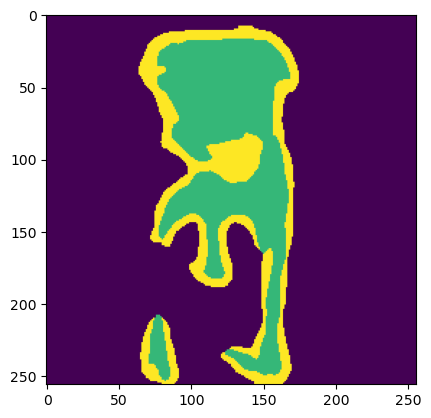

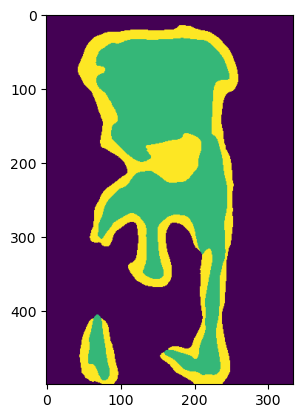

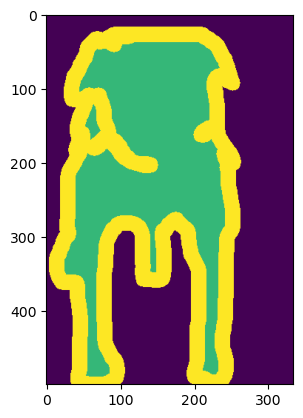

In [39]:
model = unet().to(device)
class_weight = class_weight.to(device)
loss_fn = WeightedDiceCELoss(ignore_index=3, class_weights=class_weight)


# optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=SGD_MOMENTUM,
#                       weight_decay=WEIGHT_DECAY, nesterov=True)

# total_iters = (len(train_dataloader) // accumulation_steps) * EPOCHS
# scheduler = PolynomialLR(optimizer, total_iters=total_iters, power=0.9)

checkpoint = torch.load("unet/unet_weighted_small_no_aug_same_weight.pytorch")

model.load_state_dict(checkpoint["model_state_dict"])
# optimizer.load_state_dict(checkpoint["optimizer"])
# scaler.load_state_dict(checkpoint["scaler"])

model.to(device)

images, labels = next(iter(test_dataloader))
images, meta = process_batch_forward(images, 256)

pred = model(images.to(device))

images = process_batch_reverse(pred, meta)

print(images[0].shape)

plt.imshow(pred[0].argmax(dim=0).cpu().numpy())
plt.show()
plt.imshow(images[0].argmax(dim=0).cpu().numpy())
plt.show()
plt.imshow(labels[0].permute(1,2,0).cpu().numpy())
plt.show()
# new_dev_loss = eval_loop(test_dataloader, model, loss_fn, device, 256)

## Dice Tester

In [ ]:
X, y = next(iter(train_dataloader))
X = X.to(device)
y = y.to(device)

dice = MemoryEfficientDiceLoss()

model = unet().to(device)
checkpoint = torch.load("unet/checkpoint")
model.load_state_dict(checkpoint["model"])
model.to(device)

pred = model(X[0].unsqueeze(0))

print(dice(pred, y[0].unsqueeze(0)))

In [1]:
import os; os.getcwd()

'/home/andre/Image_Segmentation'